# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [39]:
from utils import get_dataset
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
import os
import io
import math

%matplotlib inline


In [2]:
dataset = get_dataset("/home/workspace/data/train/*.tfrecord")
dataset

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


<DatasetV1Adapter shapes: {image: (None, None, 3), source_id: (), key: (), filename: (), groundtruth_image_confidences: (None,), groundtruth_verified_neg_classes: (None,), groundtruth_not_exhaustive_classes: (None,), groundtruth_boxes: (None, 4), groundtruth_area: (None,), groundtruth_is_crowd: (None,), groundtruth_difficult: (None,), groundtruth_group_of: (None,), groundtruth_weights: (None,), groundtruth_classes: (None,), groundtruth_image_classes: (None,), original_image_spatial_shape: (2,)}, types: {image: tf.uint8, source_id: tf.string, key: tf.string, filename: tf.string, groundtruth_image_confidences: tf.float32, groundtruth_verified_neg_classes: tf.int64, groundtruth_not_exhaustive_classes: tf.int64, groundtruth_boxes: tf.float32, groundtruth_area: tf.float32, groundtruth_is_crowd: tf.bool, groundtruth_difficult: tf.int64, groundtruth_group_of: tf.bool, groundtruth_weights: tf.float32, groundtruth_classes: tf.int64, groundtruth_image_classes: tf.int64, original_image_spatial_sh

## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [16]:
def display_images(batch):
    # TODO - Your implementation here
    img = batch["image"].numpy()
    # color mapping
    colormap = {1:[1,0,0],2:[0,1,0],4:[0,0,1]}
    gtboxes = batch["groundtruth_boxes"].numpy()
    classes = batch["groundtruth_classes"].numpy()
    print(classes)
    imageshape = batch["original_image_spatial_shape"].numpy()
    filename = batch["filename"].numpy().decode()
        
    # display setup
    f,ax = plt.subplots()
    ax.imshow(img)
    for cl,bb in zip(classes,gtboxes):
        y1,x1,y2,x2 = bb
        y1*= imageshape[0]
        x1*= imageshape[1]
        y2*= imageshape[0]
        x2*= imageshape[1]
        rec = patches.Rectangle((x1,y1),x2-x1,y2-y1,facecolor = 'none',edgecolor = colormap[cl])
        ax.add_patch(rec)
    ax.axis('off')
    ax.set_title(filename,fontdict = None,loc = 'center',color = "gray")
    


## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

[1 1 1 1 1 1 1 1 1 1 1]
[1]


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 432x288 with 0 Axes>

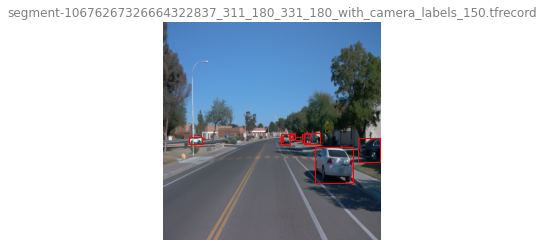

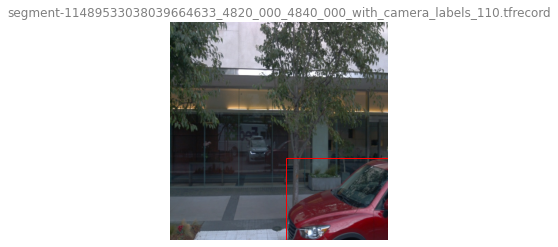

In [17]:
# Display 10 random images in dataset
plt.close("all")
batch_size = 2
batch = dataset.shuffle(batch_size,reshuffle_each_iteration = True)
plt.figure()
for i in np.arange(batch_size):
    for ii in batch.take(1):
        display_images(ii)
plt.show
    
    

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...
1. Class distribution analysis
2. ground truth confidence analysis
3. identify traffic clutter images i.e if image has more than 10 cars then add them to a bin.

In [21]:
batch_size = 1000
labels = {1:0,2:0,4:0}

for data in dataset.take(batch_size):
    obj_count = {1:0,2:0,4:0}
    for ii in data["groundtruth_classes"].numpy():
        labels[ii] +=1
        obj_count[ii]+=1
total_objects = labels[1]+labels[2]+labels[4]

vehicles = (labels[1]/total_objects)*100
pedestrians = (labels[2]/total_objects)*100
cyclist = (labels[4]/total_objects)*100

print(f" The percentage of vehicles in the images is {vehicles}% and cyclist is {cyclist}%")

 The percentage of vehicles in the images is 77.71433964044732% and cyclist is 0.6370027839380928%


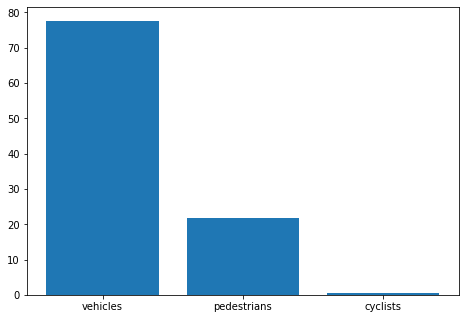

In [25]:

obj = ["vehicles","pedestrians","cyclists"]
dist = [vehicles, pedestrians, cyclist]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(obj,dist)
plt.show()

In [41]:
# number of instances per image
object_instances = {"max":0,"mean":0,"min":0}
for idx,batch in enumerate(dataset.take(1000)):
    classes = batch["groundtruth_classes"].numpy().tolist()
    
    object_instances["max"] = max(object_instances["max"],len(classes))
    object_instances["min"] = min(object_instances["min"],len(classes))
    object_instances["mean"]= math.floor((object_instances["mean"]+len(classes))/2)
object_instances

{'max': 76, 'mean': 14, 'min': 0}

25